In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

In [2]:
CAMVID_PATH = Path('/home/wesley/Documents/Code/SegNet-Tutorial/CamVid/')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [3]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

In [4]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 2
torch.cuda.manual_seed(0)

In [5]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

/home/wesley/Desktop/tesla/swa_uncertainties/experiments/segmentation/utils/training.py:110: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)
/home/wesley/anaconda3/envs/segment/lib/python3.6/site-packages/torch/nn/modules/loss.py:217: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [9]:
#state_dict = torch.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/segment_1229_sgd/checkpoint-500.pt')
state_dict = torch.load('/home/wesley/Documents/Code/pytorch_tiramisu/weights/checkpoint-500.pt')
model.load_state_dict(state_dict['state_dict'])
optimizer.load_state_dict(state_dict['optimizer'])

In [10]:
train_utils.test(model, test_loader, criterion, epoch=1)  

/home/wesley/Desktop/tesla/swa_uncertainties/experiments/segmentation/utils/training.py:91: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data.cuda(), volatile=True)


(0.5405260846655593, 0.16497991452991453)

/home/wesley/Desktop/tesla/swa_uncertainties/experiments/segmentation/utils/training.py:127: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(inputs.cuda(), volatile=True)


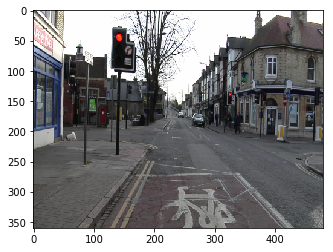

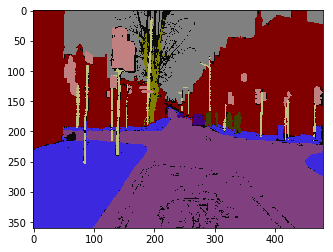

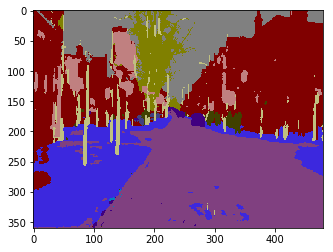

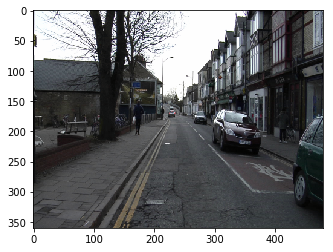

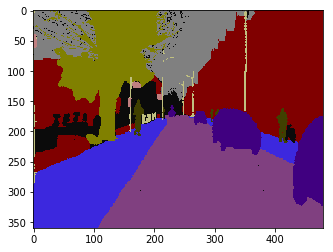

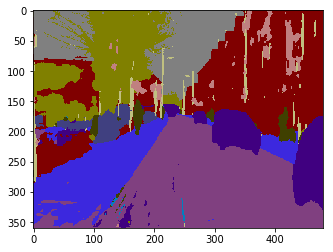

In [11]:
train_utils.view_sample_predictions(model, test_loader, n=3)

In [20]:
def compute_loss_error(loader, loc, start_epoch=25, end_epoch=900, by=25):
    test_loss, test_error = [], []
    for epoch in range(start_epoch, end_epoch+by, by):
        full_loc = loc+'/checkpoint-'+str(epoch)+'.pt'
        state_dict = torch.load(full_loc)
        model.load_state_dict(state_dict['state_dict'])
        loss, err = train_utils.test(model, loader, criterion, epoch=1)  
        print(epoch, loss, err)
        test_loss.append(loss)
        test_error.append(err)
    return test_loss, test_error

In [ ]:
sgd_val_loss, sgd_val_error = compute_loss_error(val_loader, 
                            '/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/segment_1230_constsgd/')

In [ ]:
rms_val_loss, rms_val_error = compute_loss_error(val_loader,
                             '/home/wesley/Documents/Code/pytorch_tiramisu/weights/')

Text(0.5, 0, 'Epoch')

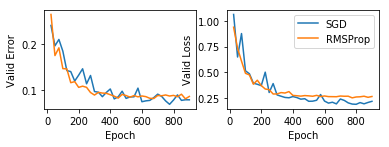

In [18]:
plt.subplot(221)
plt.plot(range(25, 925, 25), sgd_val_error, label='SGD')
plt.plot(range(25, 925, 25), rms_val_error, label='RMSProp')
#plt.legend()
plt.ylabel('Valid Error')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(range(25, 925, 25), sgd_val_loss, label='SGD')
plt.plot(range(25, 925, 25), rms_val_loss, label='RMSProp')
plt.legend()
plt.ylabel('Valid Loss')
plt.xlabel('Epoch')

In [21]:
sgd_test_loss, sgd_test_error = compute_loss_error(test_loader, 
                            '/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/segment_1230_constsgd/')

/home/wesley/Desktop/tesla/swa_uncertainties/experiments/segmentation/utils/training.py:91: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data.cuda(), volatile=True)


25 0.9838215461653522 0.27209931623931627
50 0.8395745558107001 0.2735623076923077
75 0.8503784025326754 0.2559981196581196
100 0.7739918789802454 0.25489230769230775
125 0.6286393972034128 0.20178675213675212
150 0.6030494532524011 0.1982483760683761
175 0.5776491664413713 0.18204435897435897
200 0.6368761503288889 0.2105473504273504
225 0.6222237343462105 0.19611427350427343
250 0.5722162058720222 0.1882621367521368
275 0.57750500827773 0.18784410256410247
300 0.5215787006239606 0.16050085470085468
325 0.5253175384977944 0.16488820512820507
350 0.6339195242040178 0.17108487179487183
375 0.5106449060969882 0.16226170940170945
400 0.5828049873184954 0.1819585470085469
425 0.4959659777645372 0.14401683760683762
450 0.5032621948128073 0.15450683760683764
475 0.5100638069148756 0.16888760683760684
500 0.48393834146678955 0.15315034188034196
525 0.46953173414764243 0.15110623931623926
550 0.47394538982811135 0.15049205128205123
575 0.5851040897715805 0.1855266666666666
600 0.61228655164058

In [22]:
rms_test_loss, rms_test_error = compute_loss_error(test_loader,
                             '/home/wesley/Documents/Code/pytorch_tiramisu/weights/')

25 0.9831257676466917 0.3202781196581197
50 0.7994286609001648 0.23028666666666672
75 0.7302524090832115 0.2556447008547008
100 0.6507751315067976 0.21800008547008543
125 0.6478053354299985 0.21887478632478638
150 0.6228712575557904 0.19379598290598296
175 0.6059685779942406 0.18702188034188025
200 0.5659277235340868 0.17523589743589738
225 0.5784154093673086 0.18549991452991452
250 0.5654476733289213 0.17893555555555563
275 0.5422255198160807 0.17246606837606837
300 0.5645892884996202 0.16420222222222222
325 0.5579415142026722 0.16905205128205134
350 0.5805805424849192 0.17749076923076923
375 0.5288545499500047 0.1631128205128205
400 0.5384857387114794 0.1610339316239316
425 0.5449136584742457 0.165292905982906
450 0.5414118165643806 0.1577474358974359
475 0.5639617952526125 0.17222188034188032
500 0.5405260864486042 0.16497991452991453
525 0.5566737180591649 0.16642786324786327
550 0.5710031469153543 0.16980974358974357
575 0.5352024675434471 0.15906333333333333
600 0.540762290485903

Text(0.5, 0, 'Epoch')

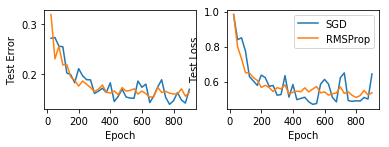

In [24]:
plt.subplot(221)
plt.plot(range(25, 925, 25), sgd_test_error, label='SGD')
plt.plot(range(25, 925, 25), rms_test_error, label='RMSProp')
#plt.legend()
plt.ylabel('Test Error')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(range(25, 925, 25), sgd_test_loss, label='SGD')
plt.plot(range(25, 925, 25), rms_test_loss, label='RMSProp')
plt.legend()
plt.ylabel('Test Loss')
plt.xlabel('Epoch')

In [12]:
sgd_loss, sgd_error = [], []
for epoch in range(25, 925, 25):
    print(epoch)
    loc = '/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/segment_1230_constsgd/checkpoint-'+str(epoch)+'.pt'
    state_dict = torch.load(loc)
    model.load_state_dict(state_dict['state_dict'])
    loss, err = train_utils.test(model, val_loader, criterion, epoch=1)  
    sgd_loss.append(loss)
    sgd_error.append(err)

25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900


In [7]:
rms_loss, rms_error = [], []
for epoch in range(25, 925, 25):
    print(epoch)
    loc = '/home/wesley/Documents/Code/pytorch_tiramisu/weights/checkpoint-'+str(epoch)+'.pt'
    state_dict = torch.load(loc)
    model.load_state_dict(state_dict['state_dict'])
    loss, err = train_utils.test(model, val_loader, criterion, epoch=1)  
    rms_loss.append(loss)
    rms_error.append(err)

25


/home/wesley/Desktop/tesla/swa_uncertainties/experiments/segmentation/utils/training.py:91: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data.cuda(), volatile=True)


50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900


Text(0.5, 0, 'Epoch')

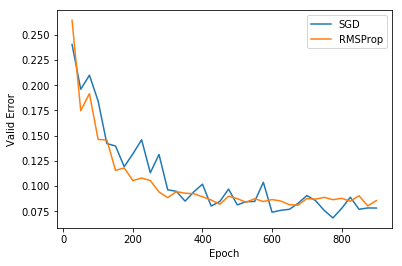

Text(0.5, 0, 'Epoch')

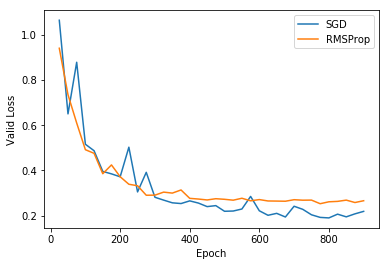